In [53]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns

%matplotlib inline

In [2]:

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

## Wumpus world

In [39]:
class WumpusWorld:
    '''
    Implementation of Wumpus World
    '''
    def __init__(
            self,
            rows:int,
            columns:int,
            start_point: tuple,
            pits: list,
            wumpus: list,
            gold: tuple,
            episodes: int,
            discount_factor: float,
            learning_rate: float,
    ) -> None:

        self.rows = rows
        self.columns = columns
        self.start_point = start_point
        self.pits = pits
        self.wumpus = cycle(wumpus)
        self.gold = gold
        self.episodes = episodes
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.arrow = True
        self.wp_alive = True
        self.gets_gold:list = []

    def initialize(self) -> None:
        self.rewards = np.zeros((self.rows, self.columns)) - 1
        for pit in self.pits:
            self.rewards[pit] = -1000
        self.old_w = next(self.wumpus)
        self.rewards[self.old_w] = -1000
        self.rewards[self.gold] = 100
        self.actions = ['up', 'down', 'right', 'left',
                        'up_s', 'down_s', 'right_s', 'left_s']

    def is_terminal_state(self, row_index: int, col_index: int) -> bool:
        if self.rewards[row_index, col_index] == -1:
            return False
        else:
            self.gets_gold.append(self.rewards[row_index,col_index])
            return True

    def move(self, current_row_index: int, current_col_index: int, action_index: int) -> tuple:
        new_row_index = current_row_index
        new_col_index = current_col_index
        shoot_col_index = current_col_index
        shoot_row_index = current_col_index
        # Move
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif self.actions[action_index] == 'down' and current_row_index < self.rows - 1:
            new_row_index += 1
        elif self.actions[action_index] == 'right' and current_col_index < self.columns - 1:
            new_col_index += 1
        elif self.actions[action_index] == 'left' and current_col_index > 0:
            new_col_index -= 1
        # Shoot
        elif self.actions[action_index] == 'up_s' and current_row_index > 0 and self.arrow:
            shoot_row_index -= 1
        elif self.actions[action_index] == 'down_s' and current_row_index < self.rows - 1 and self.arrow:
            shoot_row_index += 1
        elif self.actions[action_index] == 'right_s' and current_col_index < self.columns - 1 and self.arrow:
            shoot_col_index += 1
        elif self.actions[action_index] == 'left_s' and current_col_index > 0 and self.arrow:
            shoot_col_index -= 1

        # Compute reward
        if action_index <4:
            reward = self.rewards[new_row_index, new_col_index]
        else:
            self.arrow = False
            self.actions = self.actions[:4]
            if self.old_w == (shoot_row_index,shoot_col_index):
                reward = 50
                self.wp_alive = False
                self.rewards[self.old_w[0], self.old_w[1]] = -1
            else :
                reward = -500
        return new_row_index, new_col_index, reward

    def set_wumpus(self):
        if self.wp_alive:
            self.new_w = next(self.wumpus)
            self.rewards[self.new_w[0], self.new_w[1]] = -1000
            self.rewards[self.old_w[0], self.old_w[1]] = -1
            self.old_w = self.new_w



In [42]:
ENVIRONMENT_ROWS = 4
ENVIRONMENT_COLUMNS = 4
START_POINT = (3, 0)
PITS = [(0, 3), (2, 2), (0, 0)]
WUMPUS = [(1,0),(1,1), (2,1), (2,0)]
GOLD = (1, 2)
EPISODES = 1000
EPSILON = 0.5
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.1


ab = WumpusWorld(
    ENVIRONMENT_ROWS,
    ENVIRONMENT_COLUMNS,
    START_POINT,
    PITS,
    WUMPUS,
    GOLD,
    EPISODES,
    DISCOUNT_FACTOR,
    LEARNING_RATE
)
ab.initialize()

print(ab.rewards)


[[-1000.    -1.    -1. -1000.]
 [-1000.    -1.   100.    -1.]
 [   -1.    -1. -1000.    -1.]
 [   -1.    -1.    -1.    -1.]]


## Q-Learning

In [43]:
class QLearning(WumpusWorld):
    def __init__(
            self,
            rows: int,
            columns: int,
            start_point: tuple,
            pits: list,
            # wumpus: tuple,
            wumpus: list,
            gold: tuple,
            episodes: int,
            discount_factor: float,
            learning_rate: float
    ):
        super().__init__(
            rows,
            columns,
            start_point,
            pits,
            wumpus,
            gold,
            episodes,
            discount_factor,
            learning_rate
        )

    def initialize(self) -> None:
        super().initialize()
        # self.q_table = np.zeros((self.rows, self.rows, 4))
        self.q_table = np.zeros((self.rows, self.rows, 8))

    def next_action(self, current_row_index: int, current_col_index: int, epsilon: float) -> int:
        rand = np.random.random()
        if rand < epsilon:
            if self.arrow:
                return np.argmax(self.q_table[current_row_index, current_col_index])
            else:
                return np.argmax(self.q_table[current_row_index, current_col_index][:4])

        else:
            return np.random.randint(len(self.actions))


    def update_q_table(self, current_row: int, current_col: int,
                       action_index: int, reward: int, new_row: int, new_col: int) -> None:

        self.q_table[current_row, current_col,action_index] = \
            self.q_table[current_row,current_col,action_index] * \
                  (1 - self.learning_rate) + self.learning_rate * \
                    (reward + self.discount_factor * \
                     np.max(self.q_table[new_row, new_col]))

    def train(self) -> None:
        self.score:list = []
        for episode in tqdm.tqdm(range(self.episodes)):
            current_row, current_col = self.start_point
            ### RESET ###
            self.arrow = True
            self.wp_alive = True
            # self.actions = ['up', 'down', 'right', 'left',
            #             'up_s', 'down_s', 'right_s', 'left_s']
            ### RESET ###
            epsi = episode/self.episodes
            score = 0
            while not self.is_terminal_state(current_row, current_col):
                self.actions = ['up', 'down', 'right', 'left',
                        'up_s', 'down_s', 'right_s', 'left_s']
                action_index = self.next_action(current_row, current_col, epsi)
                new_row, new_col, reward = self.move(current_row, current_col, action_index)
                score += reward
                self.update_q_table(current_row, current_col, action_index, reward, new_row, new_col)
                current_row, current_col = new_row, new_col
                self.set_wumpus() # Added for wumpus moving
            self.score.append(score)

    def best_path(self, start_point: tuple) -> list:

        self.actions = ['up', 'down', 'right', 'left',
                    'up_s', 'down_s', 'right_s', 'left_s']
        self.arrow = True
        self.wp_alive = True
        start_row, start_col = start_point
        path = []
        if self.is_terminal_state(start_row, start_col):
            return path
        else:
            current_row, current_col = start_row, start_col
            path.append([current_row, current_col])
            while not self.is_terminal_state(current_row, current_col):
                action_index = self.next_action(current_row, current_col, 1)
                current_row, current_col, _ = self.move(current_row, current_col, action_index)
                path.append([current_row, current_col])
        return path




In [44]:
ENVIRONMENT_ROWS = 4
ENVIRONMENT_COLUMNS = 4
START_POINT = (3, 0)
PITS = [(0, 3), (2, 2), (0, 0)]
WUMPUS = [(1,0),(1,1), (2,1), (2,0)]
GOLD = (1, 2)
EPISODES = 1000
EPSILON = 0.5
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.1


ql_agent = QLearning(
    ENVIRONMENT_ROWS,
    ENVIRONMENT_COLUMNS,
    START_POINT,
    PITS,
    WUMPUS,
    GOLD,
    EPISODES,
    DISCOUNT_FACTOR,
    LEARNING_RATE
)

ql_agent.initialize()
print('Game Board')
print(ql_agent.rewards)
print('-------------------------------------------')
print('Start Training')
print('-------------------------------------------')
ql_agent.train()
print('Training Finished')
print("Path to hunt gold")
print(*ql_agent.best_path(START_POINT))

Game Board
[[-1000.    -1.    -1. -1000.]
 [-1000.    -1.   100.    -1.]
 [   -1.    -1. -1000.    -1.]
 [   -1.    -1.    -1.    -1.]]
-------------------------------------------
Start Training
-------------------------------------------


100%|██████████| 1000/1000 [00:00<00:00, 4896.11it/s]

Training Finished
Path to hunt gold
[3, 0] [3, 1] [3, 2] [3, 3] [2, 3] [1, 3] [1, 2]


145.0
0
671


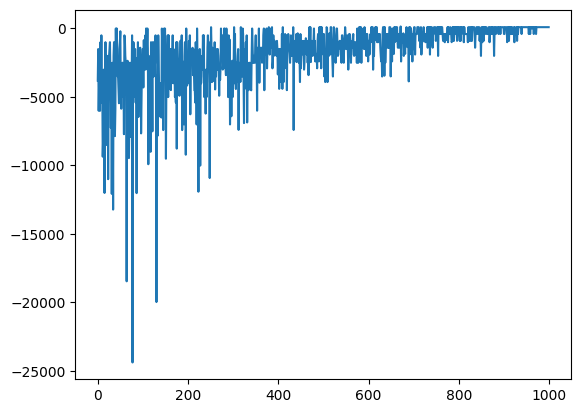

In [45]:
plt.plot(ql_agent.score)
print(max(ql_agent.score))
print(np.sum(np.array(ql_agent.score) == 97))
print(np.argmax(ql_agent.score))

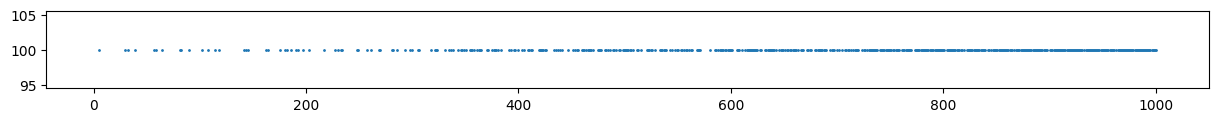

In [ ]:
idxs = [i>0 for i in ql_agent.gets_gold]
plt.figure(figsize=(15,1))
plt.scatter(np.arange(1001)[idxs],np.array(ql_agent.gets_gold)[idxs], s = 1)

## DQN

In [5]:
import random
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [16]:
class DQN(WumpusWorld):

    def __init__(
            self,
            rows: int,
            columns: int,
            start_point: tuple,
            pits: list,
            wumpus: tuple,
            gold: tuple,
            episodes: int,
            discount_factor: float,
            learning_rate: float,
            replay_memory_capacity: int,
            batch_size: int
    ):
        super().__init__(
            rows,
            columns,
            start_point,
            pits,
            wumpus,
            gold,
            episodes,
            discount_factor,
            learning_rate
        )
        self.batch_size = batch_size
        self.replay_memory_capacity = replay_memory_capacity

    def initialize(self) -> None:
        super().initialize()
        self.num_actions = len(self.actions)
        self.q_network = self.build_q_network()
        self.target_network = clone_model(self.q_network)
        self.target_network.set_weights(self.q_network.get_weights())
        self.replay_memory = []
        self.forb_x = [0,1,2,3,12,13,14,15]
        self.forb_y = [0,3,4,7,8,11,12,15]

    def build_q_network(self):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.rows*self.columns,)),
            Dense(64, activation='relu'),
            Dense(self.num_actions, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return model

    def preprocess_state(self, state):
        # Convert state to a flattened representation
        return state.flatten()

    def next_action(self, state: np.array) -> int:
        max = np.argmax(state)
        # ['up', 'down', 'right', 'left',
        #                 'up_s', 'down_s', 'right_s', 'left_s']
        # print(len(self.actions))
        acts = np.array(self.actions)
        actss = np.array(self.actions)
        if not self.arrow:
            actss = np.delete(actss,[np.where(acts==ar) for ar in ['up_s', 'down_s', 'right_s', 'left_s']])
        if max%4 == 0:
            # print('del left')
            actss = np.delete(actss,np.where(actss=='left'))
            if self.arrow:
                actss = np.delete(actss,np.where(actss=='left_s'))
            # print(actss)
        elif max%4 == 3:
            # print('del right')
            actss = np.delete(actss,np.where(actss=='right'))
            if self.arrow:
                actss = np.delete(actss,np.where(actss=='right_s'))
            # print(actss)
        if max<4 and max>= 0 :
            # print('del up')
            actss = np.delete(actss,np.where(actss=='up'))
            if self.arrow:
                actss = np.delete(actss,np.where(actss=='up_s'))
            # print(actss)
        elif max<16 and max>11:
            # print('del down')
            actss = np.delete(actss,np.where(actss=='down'))
            if self.arrow:
                actss = np.delete(actss,np.where(actss=='down_s'))
            # print(actss)
        act_idx = [np.argmax(acts==e) for e in actss]
        # print(act_idx)
        rand = np.random.random()
        if rand < self.epsilon:
            # if self.arrow:
            # print('see')
            # print(act_idx)
            # print(np.argmax(self.q_network.predict(np.array([state]),verbose=0)[0,act_idx]))
            ac_in = np.argmax(self.q_network.predict(np.array([state]),verbose=0)[0,act_idx])
            # print(act_idx)
            # print(act_idx[ac_in])
            return act_idx[ac_in]
            # else:
            #     return np.argmax(self.q_network.predict(np.array([state]),verbose=0)[0,:4])
        else:
            return np.random.choice(act_idx)

    def update_q_network(self, states, actions, rewards, next_states):
        targets = self.q_network.predict(states,verbose=0)
        next_state_targets = self.target_network.predict(next_states,verbose=0)
        for i in range(len(states)):
            # if not np.sum(self.forb_ == i) and not np.sum(self.forb_y == i):
            target = rewards[i] + self.discount_factor * np.max(next_state_targets[i])
            # elif np.sum(self.forb_x == i):
            #     if np.sum(self.forb_x[:4 == i]) and action
            #         target = -2000 + self.discount_factor * np.max(next_state_targets[i])
            targets[i, actions[i]] = target

        self.q_network.fit(states, targets, epochs=1, verbose=0)

    def store_transition(self, state, action, reward, next_state):
        self.replay_memory.append((state, action, reward, next_state))
        if len(self.replay_memory) > self.replay_memory_capacity:
            self.replay_memory.pop(0)

    def sample_transitions(self):
        transitions = random.sample(self.replay_memory, self.batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        for transition in transitions:
            states.append(transition[0])
            actions.append(transition[1])
            rewards.append(transition[2])
            next_states.append(transition[3])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)

    def train(self) -> None:
        self.score:list = []
        for episode in tqdm.tqdm(range(self.episodes)):
            current_row, current_col = self.start_point
            state = np.zeros((self.rows, self.columns))
            state[current_row, current_col] = 1
            self.epsilon = episode/self.episodes
            score = 0
            ### RESET ###
            self.arrow = True
            self.wp_alive = True
            # self.actions = ['up', 'down', 'right', 'left',
            #             'up_s', 'down_s', 'right_s', 'left_s']
            ### RESET ###
            it = 0
            while not self.is_terminal_state(current_row, current_col):

                self.actions = ['up', 'down', 'right', 'left',
                            'up_s', 'down_s', 'right_s', 'left_s']
                preprocessed_state = self.preprocess_state(state)
                action_index = self.next_action(preprocessed_state)
                # print(action_index)
                new_row, new_col, reward = self.move(current_row, current_col, action_index)
                score += reward
                new_state = np.zeros((self.rows, self.columns))
                new_state[new_row, new_col] = 1
                self.store_transition(preprocessed_state, action_index, reward, self.preprocess_state(new_state))

                # Update Q-network
                if len(self.replay_memory) >= self.batch_size:
                    states, actions, rewards, next_states = self.sample_transitions()
                    self.update_q_network(states, actions, rewards, next_states)
                current_row, current_col = new_row, new_col
                state = new_state
                self.set_wumpus()
                if it >150:
                    break
                else:
                    it+=1
            self.score.append(score)
            # Update target network every few episodes
            # if episode % 10 == 0:
            self.target_network.set_weights(self.q_network.get_weights())

    def best_path(self, start_point: tuple) -> list:

        self.actions = ['up', 'down', 'right', 'left',
                        'up_s', 'down_s', 'right_s', 'left_s']
        self.arrow = True
        self.wp_alive = True
        start_row, start_col = start_point
        path = []
        actt = []
        if self.is_terminal_state(start_row, start_col):
            return path
        else:
            current_row, current_col = start_row, start_col
            state = np.zeros((self.rows, self.columns))
            state[current_row, current_col] = 1
            path.append([current_row, current_col])
            while not self.is_terminal_state(current_row, current_col):

                self.actions = ['up', 'down', 'right', 'left',
                        'up_s', 'down_s', 'right_s', 'left_s']
                preprocessed_state = self.preprocess_state(state)
                action_index = self.next_action(preprocessed_state)
                current_row, current_col, _ = self.move(current_row, current_col, action_index)
                state = np.zeros((self.rows, self.columns))
                state[current_row, current_col] = 1
                actt.append(action_index)
                path.append([current_row, current_col])

        return path, actt

In [18]:

# Create an instance of the WumpusWorld class
ENVIRONMENT_ROWS = 4
ENVIRONMENT_COLUMNS = 4
START_POINT = (3, 0)
PITS = [(0, 3), (2, 2), (0, 0)]
WUMPUS = [(1,0),(1,1), (2,1), (2,0)]
GOLD = (1, 2)
EPISODES = 1000
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.1
REPLAY_CAP = 10000
BATCH_SIZE = 32

dqn_agent = DQN(
    ENVIRONMENT_ROWS,
    ENVIRONMENT_COLUMNS,
    START_POINT,
    PITS,
    WUMPUS,
    GOLD,
    EPISODES,
    DISCOUNT_FACTOR,
    LEARNING_RATE,
    REPLAY_CAP,
    BATCH_SIZE
)

# Initialize the world
dqn_agent.initialize()
print('Game Board')
print(dqn_agent.rewards)
print('-------------------------------------------')
print('Start Training')
print('-------------------------------------------')
# Train the agent
dqn_agent.train()


print('Training Finished')
print("Path to hunt gold")
# Find the best path
best_path, actt = dqn_agent.best_path(START_POINT)

# Print the best path
print("Best Path:")
# print(*dqn_agent.best_path(START_POINT))
print(best_path)

Game Board
[[-1000.    -1.    -1. -1000.]
 [-1000.    -1.   100.    -1.]
 [   -1.    -1. -1000.    -1.]
 [   -1.    -1.    -1.    -1.]]
-------------------------------------------
Start Training
-------------------------------------------


100%|██████████| 1000/1000 [45:00<00:00,  2.70s/it]


Training Finished
Path to hunt gold
Best Path:
[[3, 0], [3, 1], [3, 2], [3, 3], [2, 3], [1, 3], [1, 2]]


## Ending

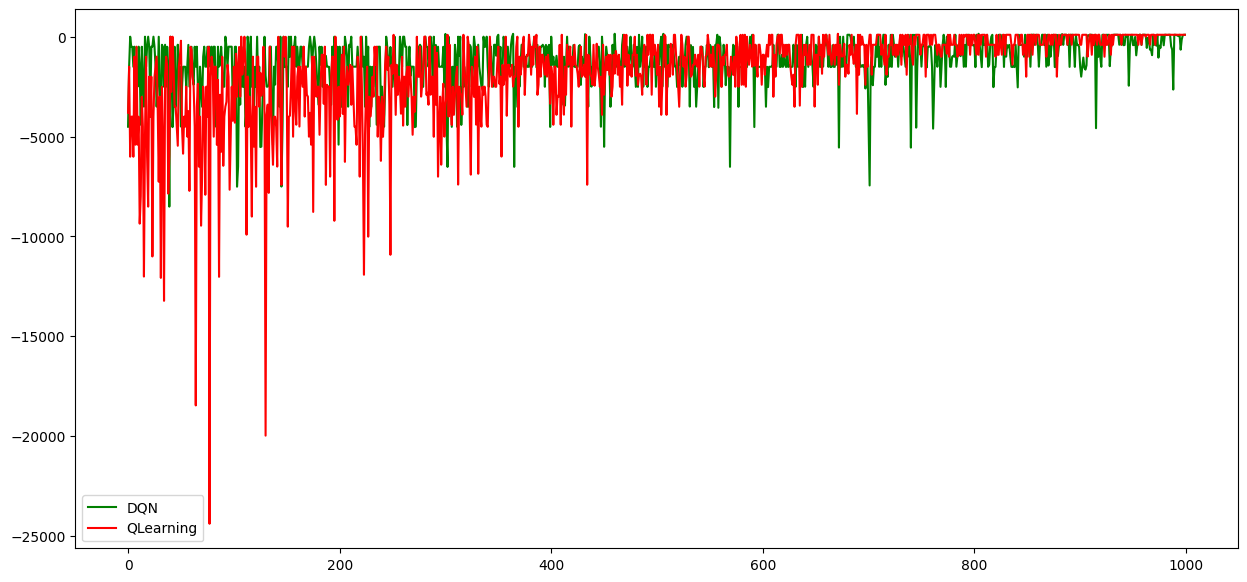

In [73]:
plt.figure(figsize=(15,7))
plt.plot(dqn_agent.score, color='green')
plt.plot(ql_agent.score, color='red')
plt.legend(['DQN', 'QLearning'])

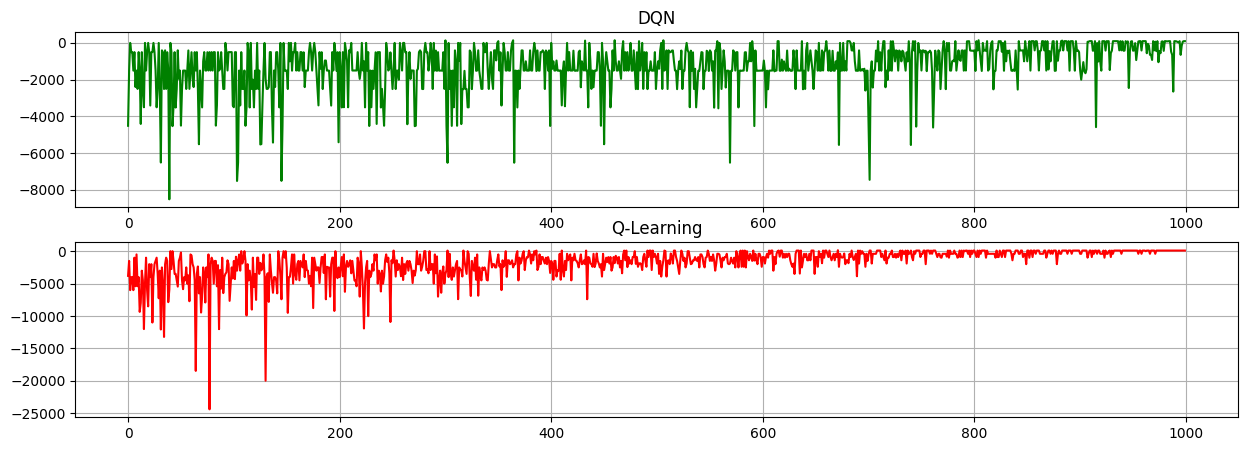

In [78]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(dqn_agent.score, color='green')
plt.title('DQN')
plt.grid()
plt.subplot(2,1,2)
plt.plot(ql_agent.score, color='red')
plt.title('Q-Learning')
plt.grid()

In [46]:
print('Q-Learning Score for the best path:')
print(ql_agent.score[-1])
print('Deep Q-Network Score for the best path:')
print(dqn_agent.score[-1])


Q-Learning Score for the best path:
95.0
Deep Q-Network Score for the best path:
95.0


<Axes: ylabel='Density'>

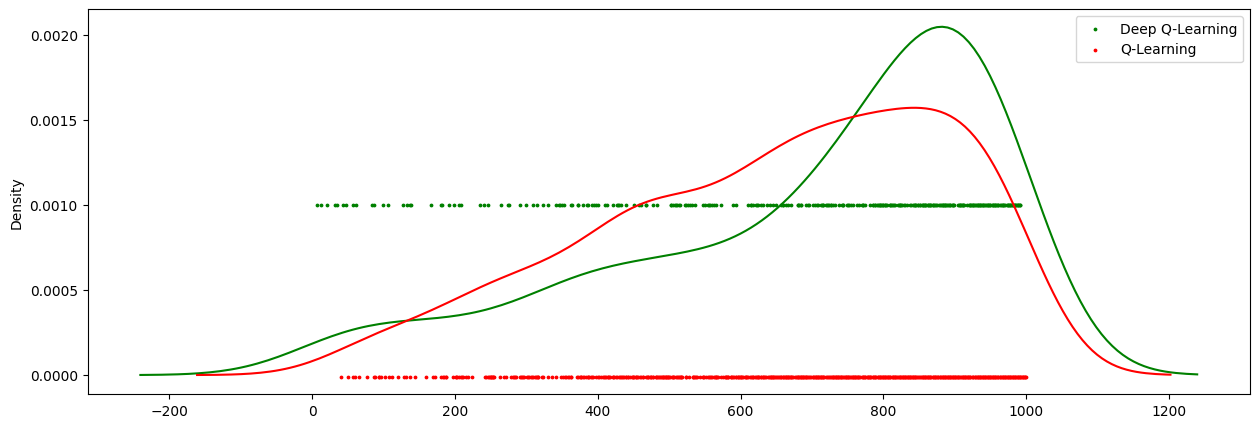

In [63]:
plt.figure(figsize=(15,5))
idxs_dqn = [i>0 for i in dqn_agent.gets_gold]
plt.scatter(np.arange(993)[idxs_dqn],np.array(dqn_agent.gets_gold)[idxs_dqn]-99.999, s = 3, c='green')
idxs = [i>0 for i in ql_agent.gets_gold]
plt.scatter(np.arange(1001)[idxs],np.array(ql_agent.gets_gold)[idxs]-100.00001, s = 3, c='red')
plt.legend(['Deep Q-Learning', 'Q-Learning'])

sns.kdeplot(np.arange(993)[idxs_dqn], color='green')
sns.kdeplot(np.arange(1001)[idxs], color= 'red')

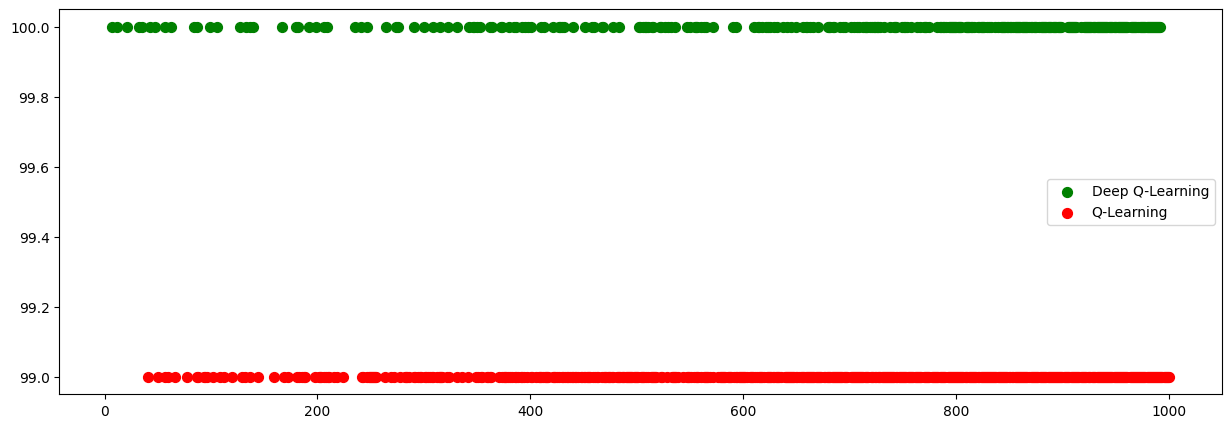

In [68]:
plt.figure(figsize=(15,5))
idxs_dqn = [i>0 for i in dqn_agent.gets_gold]
plt.scatter(np.arange(993)[idxs_dqn],np.array(dqn_agent.gets_gold)[idxs_dqn], s = 50, c='green')
idxs = [i>0 for i in ql_agent.gets_gold]
plt.scatter(np.arange(1001)[idxs],np.array(ql_agent.gets_gold)[idxs]-1, s = 50, c='red')
plt.legend(['Deep Q-Learning', 'Q-Learning'])

In [70]:
print('Q-Learning Mean score through all episodes:')
print(np.mean(ql_agent.score))
print('Deep Q-Network Mean score  through all episodes:')
print(np.mean(dqn_agent.score))

Q-Learning Mean score through all episodes:
-1726.109
Deep Q-Network Mean score  through all episodes:
-1218.964
